In [2]:
# Instalasi package "PIP" disini

!pip install tensorflow
!pip install tensorflow==2.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import Package / Library Disini
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from google.colab import files
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical


In [4]:
# Test Package / Library
print(tf.__version__)

2.12.0


In [58]:
df = pd.read_csv('/content/Train set Data Capstone Bangkit (1).csv')

# Access the sentences and labels columns
sentences = df['Kalimat'].tolist()
labels = df['Label'].tolist()

In [59]:
# Filter out any rows where the label is a float value
valid_indices = [idx for idx, label in enumerate(labels) if isinstance(label, str)]
sentences = [sentences[idx] for idx in valid_indices]
labels = [labels[idx] for idx in valid_indices]

In [60]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences to have the same length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [61]:
# Convert labels to one-hot encoding
labels_dict = {label: i for i, label in enumerate(set(labels))}
num_classes = len(labels_dict)
one_hot_labels = np.zeros((len(labels), num_classes))
for i, label in enumerate(labels):
    one_hot_labels[i, labels_dict[label]] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

In [62]:
# Load the test set from a CSV file
test_data = pd.read_csv('/content/Test Set Capstone Bangkit.csv')


In [64]:
# Preprocess the test set
tokenizer = Tokenizer()
texts = [str(text) for text in test_data['Kalimat']]  # Convert all values to string
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_test = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the labels
label_mapping = {'Rumah Sakit': 0, 'Polisi': 1, 'Pemadam Kebakaran': 2}
test_data = test_data.dropna(subset=['Label', 'Kalimat'])  # Drop rows with non-finite values in 'Label' or 'Kalimat' columns
y_test = test_data['Label'].map(label_mapping).astype(int)
y_test = to_categorical(y_test)  # Convert labels to one-hot encoded format
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

#Run the cell until x shape = y shape


X_test shape: (199, 14)
y_test shape: (199, 3)


In [77]:
# Reduce model complexity
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(50))  # Reduced number of units in LSTM layer

# Regularization and Dropout
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.6)))
model.add(Dropout(0.8))  # Dropout rate of 0.7

# Batch Normalization
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, save_weights_only=False)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)


In [78]:
num_epochs = 100
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    # Train the model for one epoch
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, callbacks=[checkpoint, early_stopping, reduce_lr])
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    
    train_loss.append(history.history['loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    
    print(f"Epoch {epoch+1} - Test Loss: {loss}, Test Accuracy: {accuracy}")


7/7 [==============================] - 0s 6ms/step - loss: 15.6784 - accuracy: 0.3367
Epoch 1 - Test Loss: 15.67835521697998, Test Accuracy: 0.3366834223270416
7/7 [==============================] - 0s 5ms/step - loss: 7.8965 - accuracy: 0.3769
Epoch 2 - Test Loss: 7.896487236022949, Test Accuracy: 0.37688443064689636
7/7 [==============================] - 0s 9ms/step - loss: 4.0614 - accuracy: 0.4171
Epoch 3 - Test Loss: 4.0613813400268555, Test Accuracy: 0.4170854389667511
7/7 [==============================] - 0s 8ms/step - loss: 2.2844 - accuracy: 0.5276
Epoch 4 - Test Loss: 2.2844085693359375, Test Accuracy: 0.5276381969451904
7/7 [==============================] - 0s 10ms/step - loss: 1.4858 - accuracy: 0.5327
Epoch 5 - Test Loss: 1.4857820272445679, Test Accuracy: 0.5326633453369141
7/7 [==============================] - 0s 6ms/step - loss: 1.1591 - accuracy: 0.5628
Epoch 6 - Test Loss: 1.1591176986694336, Test Accuracy: 0.5628140568733215
7/7 [==============================] - 

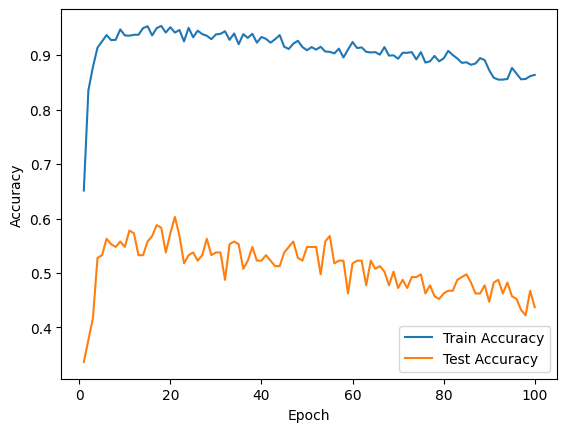

In [79]:
# Plot the accuracy
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
# Predict on new sentences
new_sentences = [
    "ada api ", "rumah saya dirampok telepon polisi", "saya butuh dokter", "saya butuh pemadam kebakaran karena ada api"]
new_sequences = tokenizer.texts_to_sequences(new_sentences)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_padded_sequences)
predicted_labels = [list(labels_dict.keys())[np.argmax(prediction)] for prediction in predictions]

# Print the predicted emergency services
for sentence, label in zip(new_sentences, predicted_labels):
    print(f"Sentence: {sentence}\nEmergency Service: {label}\n")


1/1 [==============================] - 0s 31ms/step
Sentence: ada api 
Emergency Service: Pemadam Kebakaran

Sentence: rumah saya dirampok telepon polisi
Emergency Service: Polisi

Sentence: saya butuh dokter
Emergency Service: Rumah Sakit

Sentence: saya butuh pemadam kebakaran karena ada api
Emergency Service: Pemadam Kebakaran

